# Finetuning moondream model

In [1]:
from torch.utils.data import Dataset
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm
import json
import os
from PIL import Image


c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load dataset

In [2]:
class Dataset(Dataset):
    def __init__(self, json_file_path, root_dir='.'):
        self.data = []
        self.root_dir = root_dir

        with open(json_file_path, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, id):
        sample = self.data[id]

        rel_path = sample["image_path"]

        if rel_path.startswith("./"):
            rel_path = rel_path[2:]

        img_path = os.path.join(self.root_dir, rel_path)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Nu am gasit imaginea: {img_path}")
        
        return {
            "image": image,
            "qa": [
                {
                    "question" : sample["question"],
                    "answer" : sample["answer"]
                }
            ]
        }
    
datasets = {
    "train" : Dataset(json_file_path="train.jsonl"),
    "test" : Dataset(json_file_path="test.jsonl"),
}

#### Load model

In [3]:
DEVICE = "cuda"

DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16
MD_REVISION = "2024-08-26"
model_id = "vikhyatk/moondream2"

tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    revision=MD_REVISION, 
    trust_remote_code = True,
    torch_dtype = DTYPE, device_map = {" ": DEVICE}
)

moondream = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code= True,
    revision = MD_REVISION,
    torch_dtype = DTYPE
).to(DEVICE)


PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


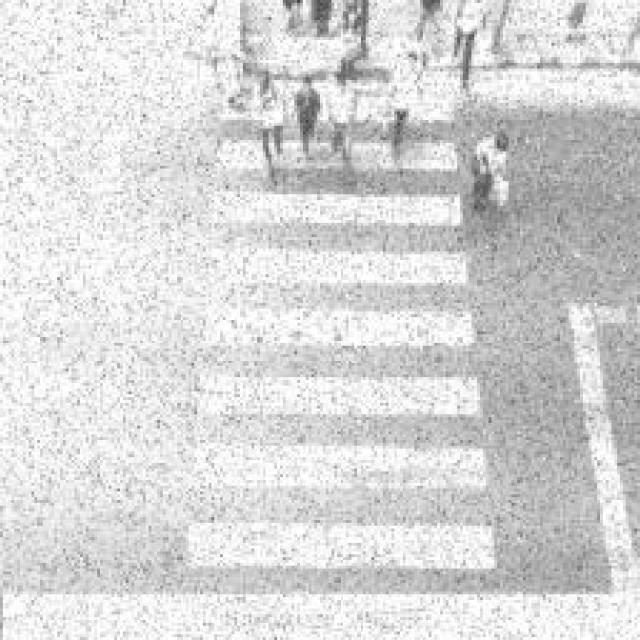

Question:
 What are the bounding boxes for the sidewalk?
Ground Truth:
 [0.53359375, 0.5078125, 0.49921875, 0.771875]
Moondream:
 The bounding boxes for the sidewalk are [0.00, 0.00, 0.99, 0.98]


In [8]:
sample = datasets['train'][0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:\n', qa['question'])
    print('Ground Truth:\n', qa['answer'])
    print('Moondream:\n', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

#### Setting up hyperparameters for fine-tuning

In [ ]:
EPOCHS = 5
BATCH_SIZE = 2
GRAD_ACCUM_STEPS = 2
LR = 1e-6
USE_WANDB = False

#### Finetuning

In [ ]:
import torch
import os
import json
import gc
from PIL import Image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model
import torchvision.transforms as T

torch.cuda.empty_cache()
gc.collect()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 

model_id = "vikhyatk/moondream2"
MD_REVISION = "2024-05-20"

EPOCHS = 3
BATCH_SIZE = 1
GRAD_ACCUM_STEPS = 16
LR = 3e-5  
print(f"🚀 Config: {DEVICE} | {DTYPE} | Batch={BATCH_SIZE} | LR={LR}")

print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    model_id, 
    revision=MD_REVISION, 
    trust_remote_code=True,
    torch_dtype=DTYPE,
    device_map={"": DEVICE}
)

def manual_preprocess(image):
    image = image.resize((378, 378), resample=Image.BICUBIC)
    img_tensor = T.ToTensor()(image) 
    img_tensor = torch.clamp(img_tensor, -1.0, 1.0)
    img_tensor = (img_tensor - 0.5) / 0.5
    return img_tensor

class Dataset(torch.utils.data.Dataset):
    def __init__(self, json_file_path, root_dir='.'):
        self.data = []
        self.root_dir = root_dir
        with open(json_file_path, 'r') as f:
            for line in f:
                try: self.data.append(json.loads(line))
                except: pass

    def __len__(self): return len(self.data)
    
    def __getitem__(self, id):
        sample = self.data[id]
        if "image_path" not in sample: return None
        
        rel_path = sample["image_path"]
        if rel_path.startswith("./"): rel_path = rel_path[2:]
        img_path = os.path.join(self.root_dir, rel_path)
        
        try: image = Image.open(img_path).convert("RGB")
        except: return None
        
        qa = None
        if "qa" in sample: qa = sample["qa"][0]
        elif "question" in sample: qa = {"question": sample["question"], "answer": sample["answer"]}
        
        if qa is None: return None

        answer_text = qa["answer"]
        if answer_text.startswith("[") and answer_text.endswith("]"):
            try:
                coords = json.loads(answer_text)
                if isinstance(coords, list) and len(coords) > 0 and isinstance(coords[0], (int, float)):
                    coords_rounded = [round(x, 3) for x in coords]
                    qa["answer"] = str(coords_rounded)
            except:
                pass

        return {"image": image, "qa": qa}

full_train_data = Dataset(json_file_path="train.jsonl")
datasets = {"train": [d for d in full_train_data if d is not None]}
print(f"✅ Images: {len(datasets['train'])}")

def get_input_embeddings_proxy():
    return moondream.text_model.get_input_embeddings()

moondream.get_input_embeddings = get_input_embeddings_proxy

target_modules = ["Wqkv", "out_proj"] 

config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    target_modules=target_modules,
    lora_dropout=0.05, 
    bias="none", 
    task_type="CAUSAL_LM"
)

if hasattr(moondream, "config"):
    moondream.config.use_cache = False
moondream.supports_gradient_checkpointing = True 
moondream.gradient_checkpointing_enable()

model = get_peft_model(moondream, config)
model.print_trainable_parameters()

optimizer = AdamW(model.parameters(), lr=LR)

def collate_fn(batch): return batch
dataloader = DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model.train()
print("\n🔥 Start Training...")

for epoch in range(EPOCHS):
    batch_loss_accum = 0
    
    for step, batch in enumerate(dataloader):
        for item in batch:
            image = item['image']
            qa = item['qa']
            
            img_tensor = manual_preprocess(image).unsqueeze(0).to(DEVICE).to(dtype=DTYPE)
            
            with torch.no_grad():
                img_embs = model.vision_encoder(img_tensor)
            
            prompt = f"<image>\n\nQuestion: {qa['question']}\n\nAnswer: {qa['answer']}"
            tokens = tokenizer(prompt, return_tensors="pt").input_ids.to(DEVICE)
            
            text_embs = model.text_model.get_input_embeddings()(tokens)
            bos = torch.tensor([[tokenizer.bos_token_id]], device=DEVICE)
            bos_embs = model.text_model.get_input_embeddings()(bos)
            
            inputs_embeds = torch.cat([bos_embs, img_embs, text_embs], dim=1)
            
            labels = torch.full(inputs_embeds.shape[:2], -100, dtype=torch.long, device=DEVICE)
            ans_tokens = tokenizer(f" {qa['answer']}", return_tensors="pt", add_special_tokens=False).input_ids
            labels[0, -ans_tokens.shape[1]:] = ans_tokens[0].to(DEVICE)
            
            outputs = model.text_model(inputs_embeds=inputs_embeds, labels=labels)
            loss = outputs.loss
            
            if torch.isnan(loss):
                optimizer.zero_grad()
                continue

            loss = loss / (BATCH_SIZE * GRAD_ACCUM_STEPS)
            loss.backward()
            batch_loss_accum += loss.item()
            
        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            optimizer.zero_grad()
            
            print(f"Epoch {epoch+1} | Step {step+1} | Loss: {batch_loss_accum:.4f}")
            batch_loss_accum = 0

    print(f"✅ Epoch {epoch+1} done.")
    model.save_pretrained(f"moondream_epoch_{epoch+1}")

print("💾 Saving final model...")
model.save_pretrained("moondream_finetuned_final")
tokenizer.save_pretrained("moondream_finetuned_final")
print("Done.")

c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Config: cuda | torch.bfloat16 | Batch=1 | LR=3e-05
Loading model...


c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


✅ Images: 771
trainable params: 4,718,592 || all params: 1,871,638,384 || trainable%: 0.2521102388334006

🔥 Start Training...


C:\Users\Moglan Calin-Stefan\.cache\huggingface\modules\transformers_modules\vikhyatk\moondream2\af5f98991c2661d0c4448ff6c2fb3c19e74f1c02\vision_encoder.py:71: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(q, k, v)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch 1 | Step 16 | Loss: 3.9014
Epoch 1 | Step 32 | Loss: 3.6113
Epoch 1 | Step 48 | Loss: 4.0029
Epoch 1 | Step 64 | Loss: 3.7949
Epoch 1 | Step 80 | Loss: 3.7217
Epoch 1 | Step 96 | Loss: 3.5879
Epoch 1 | Step 112 | Loss: 4.2100
Epoch 1 | Step 128 | Loss: 4.0898
Epoch 1 | Step 144 | Loss: 3.8477
Epoch 1 | Step 160 | Loss: 3.8467
Epoch 1 | Step 176 | Loss: 3.8975
Epoch 1 | Step 192 | Loss: 3.5938
Epoch 1 | Step 208 | Loss: 4.0234
Epoch 1 | Step 224 | Loss: 3.5781
Epoch 1 | Step 240 | Loss: 3.7061
Epoch 1 | Step 256 | Loss: 3.7227
Epoch 1 | Step 272 | Loss: 3.8311
Epoch 1 | Step 288 | Loss: 3.8418
Epoch 1 | Step 304 | Loss: 3.4092
Epoch 1 | Step 320 | Loss: 3.8242
Epoch 1 | Step 336 | Loss: 3.5713
Epoch 1 | Step 352 | Loss: 3.7295
Epoch 1 | Step 368 | Loss: 3.5635
Epoch 1 | Step 384 | Loss: 3.8027
Epoch 1 | Step 400 | Loss: 3.6055
Epoch 1 | Step 416 | Loss: 3.4834
Epoch 1 | Step 432 | Loss: 3.2080
Epoch 1 | Step 448 | Loss: 3.2939
Epoch 1 | Step 464 | Loss: 3.2783
Epoch 1 | Step 480 |

In [ ]:
import torch
import os
import json
import gc
import types
from PIL import Image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torchvision.transforms as T
from datasets import load_dataset 

torch.cuda.empty_cache()
gc.collect()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 
model_id = "vikhyatk/moondream2"
MD_REVISION = "2024-05-20"
CHECKPOINT_PATH = "moondream_finetuned_final" 

EXTRA_EPOCHS = 3
BATCH_SIZE = 1
GRAD_ACCUM_STEPS = 16
LR = 1e-5

print(f"🚀 Continuare Antrenament HIBRID (Local + VQA): {DEVICE} | {DTYPE}")

print("Încărcare model de bază...")
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=MD_REVISION)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    revision=MD_REVISION, 
    trust_remote_code=True,
    torch_dtype=DTYPE,
    device_map={"": DEVICE}
)

def get_input_embeddings_proxy(self):
    return self.text_model.get_input_embeddings()
base_model.get_input_embeddings = types.MethodType(get_input_embeddings_proxy, base_model)

if hasattr(base_model, "config"): base_model.config.use_cache = False
base_model.enable_input_require_grads()


print(f"Încărcare LoRA din '{CHECKPOINT_PATH}'...")
model = PeftModel.from_pretrained(base_model, CHECKPOINT_PATH, is_trainable=True)
model.print_trainable_parameters()

optimizer = AdamW(model.parameters(), lr=LR)

def manual_preprocess(image):
    image = image.resize((378, 378), resample=Image.BICUBIC)
    img_tensor = T.ToTensor()(image) 
    img_tensor = torch.clamp(img_tensor, -1.0, 1.0)
    img_tensor = (img_tensor - 0.5) / 0.5
    return img_tensor

class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, json_file_path, vqa_dataset=None, root_dir='.'):
        self.root_dir = root_dir
        self.local_data = []
        self.vqa_data = []

        if os.path.exists(json_file_path):
            print(f"📥 Încărcare date locale din {json_file_path}...")
            with open(json_file_path, 'r') as f:
                for line in f:
                    try: self.local_data.append(json.loads(line))
                    except: pass
        else:
            print(f"⚠️ ATENȚIE: Fișierul {json_file_path} nu există!")

        # Încărcare VQA
        if vqa_dataset:
            print(f"📥 Încărcare subset Benchmark (VQA-v2)...")
            self.vqa_data = list(vqa_dataset)

        print(f"📊 Total Dataset: {len(self.local_data)} locale + {len(self.vqa_data)} benchmark = {len(self)}")

    def __len__(self):
        return len(self.local_data) + len(self.vqa_data)

    def __getitem__(self, idx):
        # A. Date Locale
        if idx < len(self.local_data):
            sample = self.local_data[idx]
            rel_path = sample.get("image_path", "")
            if rel_path.startswith("./"): rel_path = rel_path[2:]
            img_path = os.path.join(self.root_dir, rel_path)
            
            try: image = Image.open(img_path).convert("RGB")
            except: return None
            
            qa = sample.get("qa", [None])[0] if "qa" in sample else {"question": sample.get("question"), "answer": sample.get("answer")}
            if not qa: return None
            return {"image": image, "qa": qa}

        # B. Date Benchmark
        else:
            vqa_idx = idx - len(self.local_data)
            sample = self.vqa_data[vqa_idx]
            image = sample['image'].convert("RGB")
            qa = {
                "question": sample['question'],
                "answer": sample['multiple_choice_answer'] 
            }
            return {"image": image, "qa": qa}

# --- Configurare Benchmark (FIXAT) ---
print("🌍 Conectare la VQA-v2 (Parquet Safe Version)...")
try:
    # Folosim 'merve/vqav2-small' care este format Parquet și nu necesită scripturi
    # Are split-ul 'validation', care este perfect pentru fine-tuning pe date noi
    vqa_stream = load_dataset("merve/vqav2-small", split="validation", streaming=True)
    
    vqa_subset = vqa_stream.take(500) 
    print("✅ Benchmark încărcat cu succes!")
except Exception as e:
    print(f"❌ Eroare critică la încărcarea VQA: {e}")
    vqa_subset = []

full_train_data = MixedDataset(json_file_path="train.jsonl", vqa_dataset=vqa_subset)
datasets = {"train": [d for d in full_train_data if d is not None]}

def collate_fn(batch): return batch
dataloader = DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model.train()
print("\n Start Extra Training (HIBRID - FINAL FIX)...")


for epoch in range(EXTRA_EPOCHS):
    batch_loss_accum = 0
    for step, batch in enumerate(dataloader):
        for item in batch:
            image = item['image']
            qa = item['qa']

            with torch.no_grad():
                img_embs = model.encode_image(image).to(DEVICE).to(dtype=DTYPE)

            prompt = f"\n\nQuestion: {qa['question']}\n\nAnswer: {qa['answer']}"
            
            tokens = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(DEVICE)
            text_embs = model.text_model.get_input_embeddings()(tokens)
            
            # Construim secvența: [BOS] + [IMAGE_PROIECTATA] + [TEXT]
            bos = torch.tensor([[tokenizer.bos_token_id]], device=DEVICE)
            bos_embs = model.text_model.get_input_embeddings()(bos)
            
            inputs_embeds = torch.cat([bos_embs, img_embs, text_embs], dim=1)
            
            # Labels
            labels = torch.full(inputs_embeds.shape[:2], -100, dtype=torch.long, device=DEVICE)
            
            ans_str = f" {qa['answer']}"
            ans_tokens = tokenizer(ans_str, return_tensors="pt", add_special_tokens=False).input_ids.to(DEVICE)
            # Aliniem label-urile la finalul secvenței
            labels[0, -ans_tokens.shape[1]:] = ans_tokens[0]
            
            # Forward
            outputs = model.text_model(inputs_embeds=inputs_embeds, labels=labels)
            
            loss = outputs.loss / (BATCH_SIZE * GRAD_ACCUM_STEPS)
            
            if not torch.isnan(loss):
                loss.backward()
                batch_loss_accum += loss.item()
            
        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            print(f"Epoch +{epoch+1} | Step {step+1} | Loss: {batch_loss_accum:.4f}")
            batch_loss_accum = 0

    print(f"✅ Extra Epoch {epoch+1} done.")
    model.save_pretrained(f"moondream_extended_epoch_{epoch+1}")

print("💾 Saving FINAL Hybrid model...")
model.save_pretrained("moondream_finetuned_hybrid")
print("Done.")


c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Continuare Antrenament HIBRID (Local + VQA): cuda | torch.bfloat16
Încărcare model de bază...


c:\Users\Moglan Calin-Stefan\CS UBB\SEM 5\MIRPR\Lab3\venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Încărcare LoRA din 'moondream_finetuned_final'...
trainable params: 4,718,592 || all params: 1,871,638,384 || trainable%: 0.2521102388334006
🌍 Conectare la VQA-v2 (Parquet Safe Version)...
✅ Benchmark încărcat cu succes!
📥 Încărcare date locale din train.jsonl...
📥 Încărcare subset Benchmark (VQA-v2)...
📊 Total Dataset: 771 locale + 500 benchmark = 1271

🔥 Start Extra Training (HIBRID - FINAL FIX)...
   (Utilizăm model.encode_image pentru a garanta proiecția corectă)
   (Loss-ul ar trebui să fie imediat sub 3.0)


C:\Users\Moglan Calin-Stefan\.cache\huggingface\modules\transformers_modules\vikhyatk\moondream2\af5f98991c2661d0c4448ff6c2fb3c19e74f1c02\vision_encoder.py:71: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(q, k, v)


Epoch +1 | Step 16 | Loss: 6.4512
Epoch +1 | Step 32 | Loss: 5.9312
Epoch +1 | Step 48 | Loss: 6.4072
Epoch +1 | Step 64 | Loss: 8.5078
Epoch +1 | Step 80 | Loss: 6.8916
Epoch +1 | Step 96 | Loss: 7.7080
Epoch +1 | Step 112 | Loss: 8.4375
Epoch +1 | Step 128 | Loss: 5.8594
Epoch +1 | Step 144 | Loss: 6.2676
Epoch +1 | Step 160 | Loss: 6.1152
Epoch +1 | Step 176 | Loss: 4.5215
Epoch +1 | Step 192 | Loss: 6.3188
Epoch +1 | Step 208 | Loss: 5.8799
Epoch +1 | Step 224 | Loss: 7.2979
Epoch +1 | Step 240 | Loss: 7.6641
Epoch +1 | Step 256 | Loss: 5.5784
Epoch +1 | Step 272 | Loss: 7.0557
Epoch +1 | Step 288 | Loss: 6.8145
Epoch +1 | Step 304 | Loss: 6.2393
Epoch +1 | Step 320 | Loss: 9.0410
Epoch +1 | Step 336 | Loss: 8.2188
Epoch +1 | Step 352 | Loss: 6.1121
Epoch +1 | Step 368 | Loss: 6.0918
Epoch +1 | Step 384 | Loss: 6.2949
Epoch +1 | Step 400 | Loss: 5.8403
Epoch +1 | Step 416 | Loss: 5.2104
Epoch +1 | Step 432 | Loss: 7.2803
Epoch +1 | Step 448 | Loss: 7.0498
Epoch +1 | Step 464 | Loss

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "moondream_finetuned_hybrid" 

model_id = "vikhyatk/moondream2"
revision = "2024-05-20"

tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    trust_remote_code=True, 
    revision=revision,
    torch_dtype=torch.float16,
    device_map={"": DEVICE}
)

print(f"Încărcare adapter din {MODEL_PATH}...")
model = PeftModel.from_pretrained(base_model, MODEL_PATH)
model.eval()

image_path = "poza2.jpg" 
image = Image.open(image_path)
enc_image = model.encode_image(image)

question = "Is there a sidewalk in the photo?." 
answer = model.answer_question(enc_image, question, tokenizer)

print("\nREZULTAT:")
print(f"Q: {question}")
print(f"A: {answer}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Încărcare adapter din moondream_finetuned_hybrid...

REZULTAT:
Q: Is there a sidewalk in the photo?.
A: Yes, there is a sidewalk in the photo.


In [6]:
import torch
import re
import math
import numpy as np
from tqdm import tqdm
import json
import os
import random
from PIL import Image, ImageDraw
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16
NUM_SAMPLES_TO_TEST = 50 
MODEL_PATH = "moondream_finetuned_hybrid"
BBOX_OUTPUT_DIR = "bboxes" 

print("🔄 Încărcare model Hibrid...")
model_id = "vikhyatk/moondream2"
revision = "2024-05-20"
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, revision=revision,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)
model = PeftModel.from_pretrained(base_model, MODEL_PATH)
model.eval()
print("✅ Model încărcat!")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, json_file_path, root_dir='.'):
        self.data = []
        self.root_dir = root_dir
        if os.path.exists(json_file_path):
            with open(json_file_path, 'r') as f:
                for line in f:
                    try: self.data.append(json.loads(line))
                    except: pass
    def __len__(self): return len(self.data)
    def __getitem__(self, id):
        sample = self.data[id]
        if "image_path" not in sample: return None
        rel_path = sample["image_path"]
        if rel_path.startswith("./"): rel_path = rel_path[2:]
        img_path = os.path.join(self.root_dir, rel_path)
        try: image = Image.open(img_path).convert("RGB")
        except: return None
        qa = None
        if "qa" in sample: qa = sample["qa"][0]
        elif "question" in sample: qa = {"question": sample["question"], "answer": sample["answer"]}
        if qa is None: return None
        return {"image": image, "qa": qa}

test_ds = Dataset(json_file_path="test.jsonl")
valid_test_data = [d for d in test_ds if d is not None]

def parse_bbox(text):
    try:
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", text)
        if len(nums) >= 4:
            return [float(x) for x in nums[:4]]
    except: pass
    return None

def calculate_inclusion(box_pred, box_gt):
    xA = max(box_pred[0], box_gt[0])
    yA = max(box_pred[1], box_gt[1])
    xB = min(box_pred[2], box_gt[2])
    yB = min(box_pred[3], box_gt[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    predArea = (box_pred[2] - box_pred[0]) * (box_pred[3] - box_pred[1])
    if predArea == 0: return 0.0
    return interArea / predArea

def yolo_to_xyxy(box, w_img, h_img):
    cx, cy, w, h = box
    x1 = (cx - w/2) * w_img
    y1 = (cy - h/2) * h_img
    x2 = (cx + w/2) * w_img
    y2 = (cy + h/2) * h_img
    return [x1, y1, x2, y2]

os.makedirs(BBOX_OUTPUT_DIR, exist_ok=True)
metrics = {"inclusion": [], "iou": []}

print(f"🚀 Rulare evaluare RANDOM pe {NUM_SAMPLES_TO_TEST} imagini...")
samples_to_run = random.sample(valid_test_data, min(NUM_SAMPLES_TO_TEST, len(valid_test_data)))

for i, sample in enumerate(tqdm(samples_to_run)):
    image = sample['image']
    question = sample['qa']['question']
    gt_str = sample['qa']['answer']
    
    with torch.no_grad():
        img_embs = model.encode_image(image).to(DEVICE, dtype=DTYPE)
    
    prompt = f"\n\nQuestion: {question}\n\nAnswer:"
    tokens = tokenizer(prompt, return_tensors="pt").input_ids.to(DEVICE)
    text_embs = model.text_model.get_input_embeddings()(tokens)
    bos = torch.tensor([[tokenizer.bos_token_id]], device=DEVICE)
    bos_embs = model.text_model.get_input_embeddings()(bos)
    inputs_embeds = torch.cat([bos_embs, img_embs, text_embs], dim=1)
    
    output_ids = model.text_model.generate(
        inputs_embeds=inputs_embeds, max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id, do_sample=False
    )
    pred_str = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    if "Answer:" in pred_str: pred_str = pred_str.split("Answer:")[-1].strip()
    else: pred_str = pred_str.strip()

    gt_coords = parse_bbox(gt_str)
    pred_coords = parse_bbox(pred_str)
    
    if gt_coords and pred_coords:
        w, h = image.size
        box_gt = yolo_to_xyxy(gt_coords, w, h)
        box_pred = yolo_to_xyxy(pred_coords, w, h)
        
        metrics["inclusion"].append(calculate_inclusion(box_pred, box_gt))
        
        xA = max(box_gt[0], box_pred[0])
        yA = max(box_gt[1], box_pred[1])
        xB = min(box_gt[2], box_pred[2])
        yB = min(box_gt[3], box_pred[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (box_gt[2] - box_gt[0]) * (box_gt[3] - box_gt[1])
        boxBArea = (box_pred[2] - box_pred[0]) * (box_pred[3] - box_pred[1])
        unionArea = float(boxAArea + boxBArea - interArea)
        iou = interArea / unionArea if unionArea > 0 else 0
        metrics["iou"].append(iou)
        
        img_draw = image.copy()
        draw = ImageDraw.Draw(img_draw)
        
        draw.rectangle(box_gt, outline="green", width=4)
        draw.rectangle(box_pred, outline="red", width=4)
        
        save_path = os.path.join(BBOX_OUTPUT_DIR, f"sample_{i}_iou_{iou:.2f}.jpg")
        img_draw.save(save_path)

print("\n" + "="*40)
if len(metrics["inclusion"]) > 0:
    mean_inc = sum(metrics["inclusion"]) / len(metrics["inclusion"])
    mean_iou = sum(metrics["iou"]) / len(metrics["iou"])
    valid_preds = sum(1 for x in metrics["inclusion"] if x > 0.8)
    acc_inc = (valid_preds / len(metrics["inclusion"])) * 100
    
    print(f"🛡️  Inclusion Score: {mean_inc:.4f} ({mean_inc*100:.1f}%)")
    print(f"🎯 'Safe' Accuracy:  {acc_inc:.2f}%")
    print(f"standard IoU:       {mean_iou:.4f}")
    print(f"\n📂 Imaginile cu cutii au fost salvate în folderul '{BBOX_OUTPUT_DIR}'")
else:
    print("⚠️ Nu s-au putut calcula metrici.")
print("="*40)

🔄 Încărcare model Hibrid...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


✅ Model încărcat!
🚀 Rulare evaluare RANDOM pe 50 imagini...


100%|██████████| 50/50 [10:13<00:00, 12.26s/it]


🛡️  Inclusion Score: 0.4840 (48.4%)
🎯 'Safe' Accuracy:  28.00%
standard IoU:       0.2730

📂 Imaginile cu cutii au fost salvate în folderul 'bboxes'


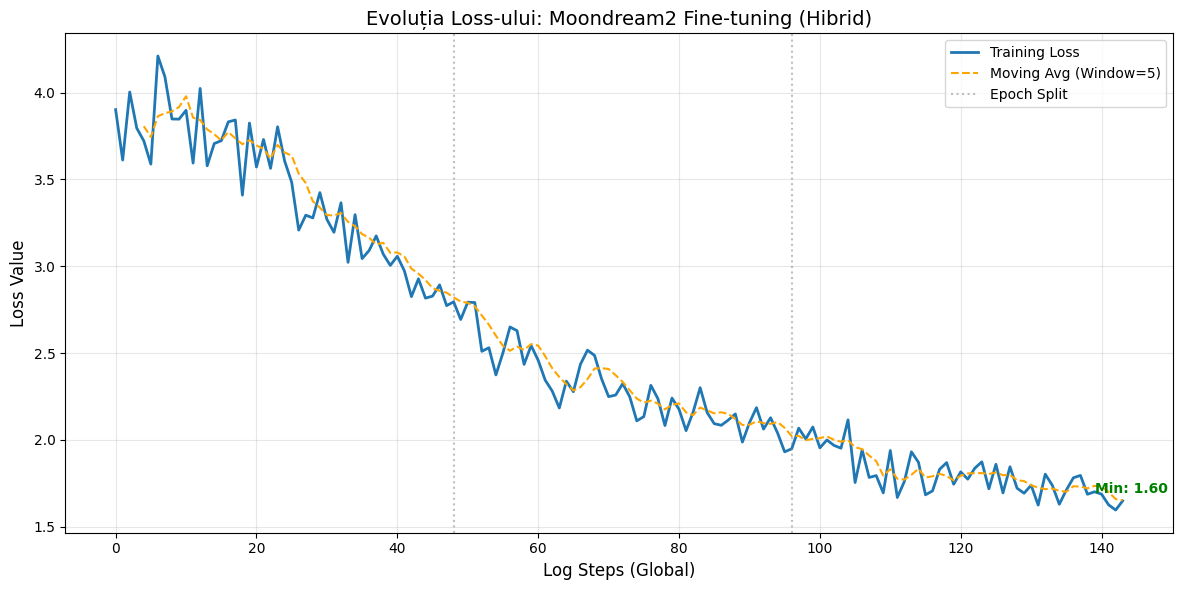

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


loss_history = [
    3.9014, 3.6113, 4.0029, 3.7949, 3.7217, 3.5879, 4.2100, 4.0898, 3.8477, 3.8467,
    3.8975, 3.5938, 4.0234, 3.5781, 3.7061, 3.7227, 3.8311, 3.8418, 3.4092, 3.8242,
    3.5713, 3.7295, 3.5635, 3.8027, 3.6055, 3.4834, 3.2080, 3.2939, 3.2783, 3.4238,
    3.2695, 3.1953, 3.3652, 3.0225, 3.2969, 3.0439, 3.0908, 3.1748, 3.0698, 3.0049,
    3.0576, 2.9736, 2.8252, 2.9277, 2.8164, 2.8281, 2.8926, 2.7734,
    2.7949, 2.6934, 2.7930, 2.7910, 2.5103, 2.5308, 2.3745, 2.5020, 2.6504, 2.6289,
    2.4351, 2.5435, 2.4585, 2.3442, 2.2812, 2.1841, 2.3384, 2.2778, 2.4355, 2.5166,
    2.4868, 2.3521, 2.2495, 2.2583, 2.3242, 2.2490, 2.1101, 2.1343, 2.3145, 2.2378,
    2.0830, 2.2412, 2.1768, 2.0537, 2.1602, 2.3008, 2.1572, 2.0938, 2.0845, 2.1147,
    2.1499, 1.9878, 2.0991, 2.1860, 2.0625, 2.1279, 2.0396, 1.9316,
    1.9492, 2.0679, 2.0059, 2.0747, 1.9546, 2.0000, 1.9688, 1.9526, 2.1157, 1.7549,
    1.9429, 1.7842, 1.7949, 1.6953, 1.9392, 1.6689, 1.7612, 1.9316, 1.8716, 1.6843,
    1.7070, 1.8311, 1.8696, 1.7451, 1.8164, 1.7744, 1.8374, 1.8740, 1.7188, 1.8599,
    1.6953, 1.8455, 1.7222, 1.6934, 1.7397, 1.6250, 1.8032, 1.7395, 1.6301, 1.7119,
    1.7822, 1.7959, 1.6875, 1.7017, 1.6880, 1.6265, 1.5967, 1.6494
]

plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Training Loss', color='#1f77b4', linewidth=2)

window = 5
moving_avg = np.convolve(loss_history, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(loss_history)), moving_avg, label=f'Moving Avg (Window={window})', color='orange', linestyle='--')

steps_per_epoch = 48 # Aproximativ cate log-uri au fost per epoca
plt.axvline(x=steps_per_epoch, color='gray', linestyle=':', alpha=0.5, label='Epoch Split')
plt.axvline(x=steps_per_epoch*2, color='gray', linestyle=':', alpha=0.5)

plt.title('Evoluția Loss-ului: Moondream2 Fine-tuning (Hibrid)', fontsize=14)
plt.xlabel('Log Steps (Global)', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

min_loss = min(loss_history)
plt.text(len(loss_history)-5, min_loss+0.1, f'Min: {min_loss:.2f}', color='green', fontweight='bold')

plt.tight_layout()
plt.show()